In [1]:
from AdaptiveKLLE import * 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.manifold import LocallyLinearEmbedding

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random

In [2]:
np.random.seed(0)
random.seed(0)

n_osservazioni = 1700
n_variabili = 17
R, r = 2, 1  
a, b = 0.1, 0.1  
r_sfera = 1  

theta = np.linspace(0, 2*np.pi, n_osservazioni)
phi = np.linspace(0, 2*np.pi, n_osservazioni)
x_toro = (R + r * np.cos(theta)) * np.cos(phi)
y_toro = (R + r * np.cos(theta)) * np.sin(phi)
z_toro = r * np.sin(theta)
toro = np.column_stack((x_toro, y_toro, z_toro))
toro = np.hstack([toro]+[np.random.normal(0, 0.05, (n_osservazioni, 3))] + [np.random.normal(0, 0.05, (n_osservazioni, n_variabili - 3))])

t = np.linspace(0, 20*np.pi, n_osservazioni)
x_spirale = a * t * np.cos(t)
y_spirale = a * t * np.sin(t)
z_spirale = b * t
spirale_3d = np.column_stack((x_spirale, y_spirale, z_spirale))
spirale_3d = np.hstack([spirale_3d]+[np.random.normal(0, 0.05, (n_osservazioni, 3))] + [np.random.normal(0, 0.05, (n_osservazioni, n_variabili - 3))])

np.random.seed(0)
phi = np.random.uniform(0, np.pi, n_osservazioni)
theta = np.random.uniform(0, 2*np.pi, n_osservazioni)
x_sfera = r_sfera * np.sin(phi) * np.cos(theta)
y_sfera = r_sfera * np.sin(phi) * np.sin(theta)
z_sfera = r_sfera * np.cos(phi)
sfera = np.column_stack((x_sfera, y_sfera, z_sfera))
sfera = np.hstack([sfera]+[np.random.normal(0, 0.05, (n_osservazioni, 3))] + [np.random.normal(0, 0.05, (n_osservazioni, n_variabili - 3))])

dataframes_complessi = [pd.DataFrame(toro), pd.DataFrame(spirale_3d), pd.DataFrame(sfera)]
X = pd.concat(dataframes_complessi, ignore_index=True).values.astype(float)
y = np.repeat(np.arange(0, 3), n_osservazioni)

In [3]:
#Using default parameters of sklearn implementation

lle = LocallyLinearEmbedding(random_state=0)
embs_ll = lle.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(embs_ll)
lab_lle = kmeans.labels_

print(adjusted_rand_score(lab_lle, y))
print(homogeneity_completeness_v_measure(lab_lle, y))

/Users/federico.ravenda/anaconda3/envs/MOOD/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.31808762152019204
(0.5820443029499878, 0.4215175431528092, 0.4889422321869285)


# Adaptive LLE

In [4]:
r = 'opt'
Dthr = 6.667

k_star_lle = K_starLLE(X = X, initial_id = None, n_iter = 10)
Y_kstar_lle, W_lle, kstars = k_star_lle.calculate_embedding(initial_id=None, Dthr=Dthr, r = r)

iteration  0
id  [10.5]
iteration  1
id  [5.41]
iteration  2
id  [4.56]
iteration  3
id  [4.05]
iteration  4
id  [3.69]
iteration  5
id  [3.46]
iteration  6
id  [3.37]
iteration  7
id  [3.32]
iteration  8
id  [3.31]
iteration  9
id  [3.3]


In [5]:
sc = KMeans(n_clusters=3, random_state=0)
sc.fit(Y_kstar_lle)
lab_kstar = sc.labels_
print(adjusted_rand_score(lab_kstar, y))
print(homogeneity_completeness_v_measure(lab_kstar, y))

/Users/federico.ravenda/anaconda3/envs/MOOD/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.7193141476615889
(0.6953900146118172, 0.6894763226071726, 0.6924205422093197)


In [6]:
import warnings 
warnings.filterwarnings('ignore')

n_neighs = [5, 10, 15, 20, 25, 30, 35, 40,  45, 49, 50, 55, 60, 65, 70, 75]

ari_kmeans = []
hcv_kmeans = []

for NN in n_neighs: 
    lle = LocallyLinearEmbedding(random_state=0, n_components=3, n_neighbors=NN, n_jobs=-1)
    embs_ll = lle.fit_transform(X)
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(embs_ll)
    lab_lle = kmeans.labels_
    ari_kmeans.append(adjusted_rand_score(lab_lle, y))
    hcv_kmeans.append(list(homogeneity_completeness_v_measure(lab_lle, y)))

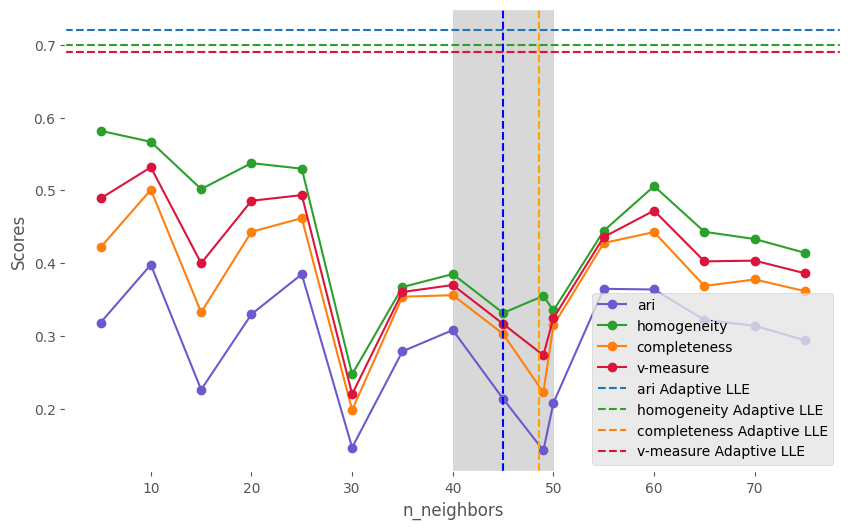

In [8]:
ari_horizontal = .72
hcv_horizontal = np.array([0.70, 0.69, 0.69])

ari_color = '#1f77b4'
completeness_color = '#ff7f0e'
homogeneity_color = '#2ca02c'
vmeasure_color = 'crimson'

plt.figure(figsize=(10, 6))

plt.plot(n_neighs, ari_kmeans, label='ari', marker='o', color='slateblue')

hcv_kmeans = np.array(hcv_kmeans)
plt.plot(n_neighs, hcv_kmeans[:, 0], label='homogeneity', marker='o', color=homogeneity_color)
plt.plot(n_neighs, hcv_kmeans[:, 1], label='completeness', marker='o', color=completeness_color)
plt.plot(n_neighs, hcv_kmeans[:, 2], label='v-measure', marker='o', color=vmeasure_color)

plt.axhline(y=ari_horizontal, color=ari_color, linestyle='--', label='ari Adaptive LLE')
plt.axhline(y=hcv_horizontal[0], color=homogeneity_color, linestyle='--', label='homogeneity Adaptive LLE')
plt.axhline(y=hcv_horizontal[1], color=completeness_color, linestyle='--', label='completeness Adaptive LLE')
plt.axhline(y=hcv_horizontal[2], color=vmeasure_color, linestyle='--', label='v-measure Adaptive LLE')

plt.axvline(x=45, color='blue', linestyle='--')
plt.axvline(x=48.6, color='orange', linestyle='--')

plt.axvspan(40, 50, color='gray', alpha=0.3)

plt.title('')
plt.xlabel('n_neighbors')
plt.ylabel('Scores')
plt.legend(loc='lower right')

plt.gca().set_facecolor('white')

plt.grid(True)
#plt.savefig('plot_.pdf')
plt.show()